# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [1]:
! pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

     - 11.7MB 73.4MB/s
Requirement already up-to-date: six in ./anaconda3/envs/py34/lib/python3.4/site-packages (from agentnet==0.10.6)
Requirement already up-to-date: lasagne in ./AgentNet/src/lasagne (from agentnet==0.10.6)
Requirement already up-to-date: theano>=0.8.2 in ./anaconda3/envs/py34/lib/python3.4/site-packages (from agentnet==0.10.6)
Requirement already up-to-date: numpy>=1.9 in ./anaconda3/envs/py34/lib/python3.4/site-packages (from agentnet==0.10.6)
Requirement already up-to-date: scipy>=0.14 in ./anaconda3/envs/py34/lib/python3.4/site-packages (from theano>=0.8.2->agentnet==0.10.6)
  Found existing installation: agentnet 0.10.6
    Uninstalling agentnet-0.10.6:
      Successfully uninstalled agentnet-0.10.6
  Running setup.py install for agentnet ... - \ | done


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


### Experiment setup
* Here we simply load the game and check that it works

In [21]:
import gym
make_env = lambda: gym.make("LunarLander-v2")

env = gym.make("LunarLander-v2")
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

In [22]:
print(state_shape)

(8,)


In [23]:
# plt.imshow(env.render("rgb_array"))
# del env

# Neural Network body

In [25]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import *
# from lasagne.nonlinearities import relu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
# inp_layer = InputLayer((None, 3, 8, 8))
observation_layer = InputLayer((None, ) + state_shape)

net = DenseLayer(observation_layer, 200, nonlinearity=elu)
net = DenseLayer(net, 200, nonlinearity=elu)
# nn = DenseLayer(nn, 200)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(net, num_units=n_actions,
                           nonlinearity=None,name="q-values")

Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [26]:
from agentnet.resolver import EpsilonGreedyResolver

In [27]:
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))

### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [28]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)

In [29]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [30]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

In [31]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

actions: [[3 3 3 3 3]]
rewards: [[ 0.37330229  0.70081269  0.80600002  0.5066763   0.        ]]
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 9.39 ms


In [32]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [39]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [40]:
from lasagne.regularization import regularize_network_params, l2
l2_penalty = regularize_network_params(qvalues_layer, l2)

In [74]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum() + 0.2 * l2_penalty

In [75]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Training loop

In [76]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = 0

In [77]:
from tqdm import trange

for i in trange(10000):    
    
    #play
    for _ in range(7):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.04 + 0.96*np.exp(-epoch_counter/15000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win! ", rewards[epoch_counter])
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 100/10000 [00:12<19:55,  8.28it/s]

Episode finished after 84 timesteps with reward=-132.38785627380872
Episode finished after 73 timesteps with reward=-169.91303183272197
Episode finished after 95 timesteps with reward=-370.8285878747901
iter=100	epsilon=0.995
Current score(mean over 3) = -224.376


  2%|▏         | 200/10000 [00:22<18:29,  8.83it/s]

Episode finished after 133 timesteps with reward=-514.1016374544689
Episode finished after 76 timesteps with reward=-280.3729726319405
Episode finished after 73 timesteps with reward=-137.11482781921444
iter=200	epsilon=0.990
Current score(mean over 3) = -310.530


  3%|▎         | 300/10000 [00:33<17:59,  8.98it/s]

Episode finished after 76 timesteps with reward=-131.61429869719845
Episode finished after 78 timesteps with reward=-133.06684597464695
Episode finished after 65 timesteps with reward=-128.0439063003337
iter=300	epsilon=0.986
Current score(mean over 3) = -130.908


  4%|▍         | 400/10000 [00:45<18:13,  8.78it/s]

Episode finished after 87 timesteps with reward=-427.3369777821142
Episode finished after 67 timesteps with reward=-119.51058996305179
Episode finished after 71 timesteps with reward=-144.69449455767966
iter=400	epsilon=0.981
Current score(mean over 3) = -230.514


  5%|▌         | 500/10000 [00:56<17:54,  8.85it/s]

Episode finished after 95 timesteps with reward=-204.77381604417823
Episode finished after 64 timesteps with reward=-183.42444736988622
Episode finished after 118 timesteps with reward=-144.06133659370644
iter=500	epsilon=0.976
Current score(mean over 3) = -177.420


  6%|▌         | 599/10000 [01:07<17:32,  8.93it/s]

Episode finished after 78 timesteps with reward=-128.51097545940192
Episode finished after 121 timesteps with reward=-234.5135758757648
Episode finished after 128 timesteps with reward=-55.691605691393995
iter=600	epsilon=0.972
Current score(mean over 3) = -139.572


  7%|▋         | 700/10000 [01:18<17:16,  8.97it/s]

Episode finished after 71 timesteps with reward=-179.8922471655298
Episode finished after 104 timesteps with reward=-341.4816993956381
Episode finished after 83 timesteps with reward=-197.31482253973388
iter=700	epsilon=0.967
Current score(mean over 3) = -239.563


  8%|▊         | 800/10000 [01:29<17:04,  8.98it/s]

Episode finished after 93 timesteps with reward=-156.59985112238178
Episode finished after 112 timesteps with reward=-171.25974348541743
Episode finished after 103 timesteps with reward=-457.12020079844405
iter=800	epsilon=0.962
Current score(mean over 3) = -261.660


  9%|▉         | 899/10000 [01:39<16:49,  9.01it/s]

Episode finished after 67 timesteps with reward=-106.60062648397178
Episode finished after 127 timesteps with reward=-231.4524888704306


  9%|▉         | 901/10000 [01:40<16:52,  8.99it/s]

Episode finished after 137 timesteps with reward=-159.17978061983
iter=900	epsilon=0.958
Current score(mean over 3) = -165.744


 10%|█         | 1000/10000 [01:50<16:36,  9.03it/s]

Episode finished after 105 timesteps with reward=-147.32855694868113
Episode finished after 78 timesteps with reward=-291.77402884559655
Episode finished after 72 timesteps with reward=-125.39061724266853
iter=1000	epsilon=0.953
Current score(mean over 3) = -188.164


 11%|█         | 1100/10000 [02:01<16:22,  9.06it/s]

Episode finished after 64 timesteps with reward=-139.34644404105933
Episode finished after 101 timesteps with reward=-145.83751229803443
Episode finished after 114 timesteps with reward=-323.29092976326206
iter=1100	epsilon=0.949
Current score(mean over 3) = -202.825


 12%|█▏        | 1200/10000 [02:12<16:09,  9.07it/s]

Episode finished after 130 timesteps with reward=-261.8722471436246
Episode finished after 128 timesteps with reward=-381.59797255534806
Episode finished after 119 timesteps with reward=-136.73529095347828
iter=1200	epsilon=0.944
Current score(mean over 3) = -260.069


 13%|█▎        | 1300/10000 [02:23<15:57,  9.09it/s]

Episode finished after 82 timesteps with reward=-136.43880733285576
Episode finished after 95 timesteps with reward=-140.53034537081768
Episode finished after 121 timesteps with reward=-357.119218407166
iter=1300	epsilon=0.940
Current score(mean over 3) = -211.363


 14%|█▍        | 1400/10000 [02:33<15:45,  9.10it/s]

Episode finished after 79 timesteps with reward=-187.84312114460798
Episode finished after 77 timesteps with reward=-150.10672557972507
Episode finished after 109 timesteps with reward=-301.81964286102095
iter=1400	epsilon=0.935
Current score(mean over 3) = -213.256


 15%|█▌        | 1500/10000 [02:44<15:33,  9.11it/s]

Episode finished after 76 timesteps with reward=-375.8945589560726
Episode finished after 67 timesteps with reward=-109.28124811741348
Episode finished after 93 timesteps with reward=-309.66665261293304
iter=1500	epsilon=0.931
Current score(mean over 3) = -264.947


 16%|█▌        | 1600/10000 [02:55<15:22,  9.11it/s]

Episode finished after 94 timesteps with reward=-262.9064098024853
Episode finished after 98 timesteps with reward=-303.1032853994915
Episode finished after 60 timesteps with reward=-99.60629124076021
iter=1600	epsilon=0.926
Current score(mean over 3) = -221.872


 17%|█▋        | 1700/10000 [03:06<15:11,  9.11it/s]

Episode finished after 113 timesteps with reward=-192.79398118308248
Episode finished after 80 timesteps with reward=-304.99039879361624
Episode finished after 80 timesteps with reward=-141.62801184299957
iter=1700	epsilon=0.922
Current score(mean over 3) = -213.137


 18%|█▊        | 1799/10000 [03:18<15:04,  9.06it/s]

Episode finished after 101 timesteps with reward=-204.3674160799792
Episode finished after 126 timesteps with reward=-380.64531168045335
Episode finished after 132 timesteps with reward=-323.2011959206933


 18%|█▊        | 1801/10000 [03:18<15:05,  9.05it/s]

iter=1800	epsilon=0.917
Current score(mean over 3) = -302.738


 19%|█▉        | 1900/10000 [03:29<14:53,  9.06it/s]

Episode finished after 110 timesteps with reward=-236.10507899562757
Episode finished after 83 timesteps with reward=-345.4823505090752
Episode finished after 110 timesteps with reward=-160.214189940164
iter=1900	epsilon=0.913
Current score(mean over 3) = -247.267


 20%|██        | 2000/10000 [03:40<14:41,  9.07it/s]

Episode finished after 67 timesteps with reward=-123.92074241196528
Episode finished after 63 timesteps with reward=-93.83297601396183
Episode finished after 87 timesteps with reward=-232.19756064450067
iter=2000	epsilon=0.909
Current score(mean over 3) = -149.984


 21%|██        | 2100/10000 [03:52<14:35,  9.02it/s]

Episode finished after 109 timesteps with reward=-283.20031318024394
Episode finished after 103 timesteps with reward=-125.61873043674122
Episode finished after 105 timesteps with reward=-243.3223503892229
iter=2100	epsilon=0.904
Current score(mean over 3) = -217.380


 22%|██▏       | 2200/10000 [04:03<14:24,  9.03it/s]

Episode finished after 81 timesteps with reward=-173.82632615912837
Episode finished after 67 timesteps with reward=-91.48096461431564
Episode finished after 112 timesteps with reward=-123.9993093862093
iter=2200	epsilon=0.900
Current score(mean over 3) = -129.769


 23%|██▎       | 2300/10000 [04:16<14:19,  8.96it/s]

Episode finished after 108 timesteps with reward=-390.7900458238953
Episode finished after 117 timesteps with reward=-302.45532178468125
Episode finished after 70 timesteps with reward=-143.75427166009018
iter=2300	epsilon=0.896
Current score(mean over 3) = -279.000


 24%|██▍       | 2400/10000 [04:27<14:08,  8.96it/s]

Episode finished after 69 timesteps with reward=-210.06967655232734
Episode finished after 70 timesteps with reward=-242.1126598608518
Episode finished after 77 timesteps with reward=-108.21537985014898
iter=2400	epsilon=0.891
Current score(mean over 3) = -186.799


 25%|██▌       | 2500/10000 [04:38<13:56,  8.97it/s]

Episode finished after 112 timesteps with reward=-218.67914591651245
Episode finished after 73 timesteps with reward=-171.66085158324555
Episode finished after 109 timesteps with reward=-325.3523905035852
iter=2500	epsilon=0.887
Current score(mean over 3) = -238.564


 26%|██▌       | 2600/10000 [04:49<13:45,  8.97it/s]

Episode finished after 108 timesteps with reward=-202.0445173597688
Episode finished after 79 timesteps with reward=-224.18329563240644
Episode finished after 116 timesteps with reward=-307.2909415577905
iter=2600	epsilon=0.883
Current score(mean over 3) = -244.506


 27%|██▋       | 2700/10000 [05:00<13:33,  8.98it/s]

Episode finished after 84 timesteps with reward=-193.49590927722795
Episode finished after 67 timesteps with reward=-103.2536901796773
Episode finished after 76 timesteps with reward=-258.0517149524386
iter=2700	epsilon=0.879
Current score(mean over 3) = -184.934


 28%|██▊       | 2800/10000 [05:11<13:21,  8.99it/s]

Episode finished after 105 timesteps with reward=-203.81052669941585
Episode finished after 86 timesteps with reward=-342.89247146676604
Episode finished after 82 timesteps with reward=-142.4565228837247
iter=2800	epsilon=0.875
Current score(mean over 3) = -229.720


 29%|██▉       | 2900/10000 [05:22<13:09,  9.00it/s]

Episode finished after 148 timesteps with reward=-137.27730935561485
Episode finished after 102 timesteps with reward=-233.33328638502627
Episode finished after 114 timesteps with reward=-334.91907422322276
iter=2900	epsilon=0.870
Current score(mean over 3) = -235.177


 30%|██▉       | 2999/10000 [05:33<12:57,  9.00it/s]

Episode finished after 133 timesteps with reward=-217.0176753096926
Episode finished after 133 timesteps with reward=-522.4587894419508


 30%|███       | 3001/10000 [05:33<12:58,  8.99it/s]

Episode finished after 150 timesteps with reward=-199.81201754743117
iter=3000	epsilon=0.866
Current score(mean over 3) = -313.096


 31%|███       | 3100/10000 [05:44<12:46,  9.00it/s]

Episode finished after 74 timesteps with reward=-160.12697696949402
Episode finished after 101 timesteps with reward=-262.5663367953385
Episode finished after 116 timesteps with reward=-304.7021280185179
iter=3100	epsilon=0.862
Current score(mean over 3) = -242.465


 32%|███▏      | 3199/10000 [05:54<12:34,  9.02it/s]

Episode finished after 122 timesteps with reward=-159.7902303861862
Episode finished after 129 timesteps with reward=-131.91086543929904


 32%|███▏      | 3201/10000 [05:55<12:34,  9.01it/s]

Episode finished after 127 timesteps with reward=-141.8162128937493
iter=3200	epsilon=0.858
Current score(mean over 3) = -144.506


 33%|███▎      | 3300/10000 [06:05<12:22,  9.02it/s]

Episode finished after 79 timesteps with reward=-175.58780943527924
Episode finished after 101 timesteps with reward=-216.8973997886443
Episode finished after 101 timesteps with reward=-200.39218982851088
iter=3300	epsilon=0.854
Current score(mean over 3) = -197.626


 34%|███▍      | 3400/10000 [06:16<12:11,  9.02it/s]

Episode finished after 121 timesteps with reward=-377.84229772511236
Episode finished after 101 timesteps with reward=-244.43594697946128
Episode finished after 114 timesteps with reward=-172.81944094505704
iter=3400	epsilon=0.850
Current score(mean over 3) = -265.033


 35%|███▌      | 3500/10000 [06:28<12:00,  9.02it/s]

Episode finished after 189 timesteps with reward=-427.1761369109022
Episode finished after 70 timesteps with reward=-195.22034177888688
Episode finished after 114 timesteps with reward=-198.29017129234168
iter=3500	epsilon=0.846
Current score(mean over 3) = -273.562


 36%|███▌      | 3599/10000 [06:38<11:49,  9.02it/s]

Episode finished after 88 timesteps with reward=-55.49248927725077
Episode finished after 131 timesteps with reward=-343.4237442020892


 36%|███▌      | 3600/10000 [06:39<11:50,  9.01it/s]

Episode finished after 174 timesteps with reward=-288.0133371445169
iter=3600	epsilon=0.842
Current score(mean over 3) = -228.977


 37%|███▋      | 3700/10000 [06:51<11:40,  9.00it/s]

Episode finished after 112 timesteps with reward=-235.0946356298176
Episode finished after 86 timesteps with reward=-172.02143200465227
Episode finished after 73 timesteps with reward=-137.94523192274553
iter=3700	epsilon=0.838
Current score(mean over 3) = -181.687


 38%|███▊      | 3799/10000 [07:01<11:28,  9.01it/s]

Episode finished after 79 timesteps with reward=-208.1490237196531
Episode finished after 174 timesteps with reward=-274.0526794875965


 38%|███▊      | 3801/10000 [07:02<11:28,  9.00it/s]

Episode finished after 121 timesteps with reward=-166.394274465757
iter=3800	epsilon=0.834
Current score(mean over 3) = -216.199


 39%|███▉      | 3899/10000 [07:14<11:19,  8.98it/s]

Episode finished after 167 timesteps with reward=-247.95330438355384
Episode finished after 85 timesteps with reward=-105.21835572951886


 39%|███▉      | 3901/10000 [07:14<11:20,  8.97it/s]

Episode finished after 181 timesteps with reward=-368.7969831469911
iter=3900	epsilon=0.830
Current score(mean over 3) = -240.656


 40%|████      | 4000/10000 [07:25<11:08,  8.98it/s]

Episode finished after 116 timesteps with reward=-284.100236531312
Episode finished after 97 timesteps with reward=-94.6800640484672
Episode finished after 118 timesteps with reward=-250.00827470768394
iter=4000	epsilon=0.826
Current score(mean over 3) = -209.596


 41%|████      | 4100/10000 [07:36<10:56,  8.98it/s]

Episode finished after 139 timesteps with reward=-364.52255569238577
Episode finished after 103 timesteps with reward=-104.42479145636288
Episode finished after 116 timesteps with reward=-108.27160273044814
iter=4100	epsilon=0.822
Current score(mean over 3) = -192.406


 42%|████▏     | 4200/10000 [07:48<10:47,  8.96it/s]

Episode finished after 122 timesteps with reward=-253.72494916431143
Episode finished after 82 timesteps with reward=-120.91558480621163
Episode finished after 76 timesteps with reward=-222.3604678221103
iter=4200	epsilon=0.818
Current score(mean over 3) = -199.000


 43%|████▎     | 4300/10000 [08:01<10:38,  8.93it/s]

Episode finished after 105 timesteps with reward=-180.21006247901045
Episode finished after 128 timesteps with reward=-110.4270633559841
Episode finished after 82 timesteps with reward=-150.7408685249651
iter=4300	epsilon=0.814
Current score(mean over 3) = -147.126


 44%|████▍     | 4399/10000 [08:11<10:26,  8.94it/s]

Episode finished after 137 timesteps with reward=-186.405163023481
Episode finished after 165 timesteps with reward=-292.5763845965145


 44%|████▍     | 4401/10000 [08:12<10:26,  8.94it/s]

Episode finished after 122 timesteps with reward=-164.9546615160342
iter=4400	epsilon=0.810
Current score(mean over 3) = -214.645


 45%|████▌     | 4500/10000 [08:23<10:15,  8.93it/s]

Episode finished after 125 timesteps with reward=-228.47852370444525
Episode finished after 103 timesteps with reward=-236.54597441139865
Episode finished after 107 timesteps with reward=-443.0730168605126
iter=4500	epsilon=0.807
Current score(mean over 3) = -302.699


 46%|████▌     | 4600/10000 [08:35<10:05,  8.92it/s]

Episode finished after 112 timesteps with reward=-200.47658428925158
Episode finished after 96 timesteps with reward=-167.70135821867365
Episode finished after 118 timesteps with reward=-207.33748791714686
iter=4600	epsilon=0.803
Current score(mean over 3) = -191.838


 47%|████▋     | 4700/10000 [08:48<09:55,  8.89it/s]

Episode finished after 105 timesteps with reward=-248.23252722101785
Episode finished after 93 timesteps with reward=-119.76001290786552
Episode finished after 116 timesteps with reward=-181.98737987031427
iter=4700	epsilon=0.799
Current score(mean over 3) = -183.327


 48%|████▊     | 4800/10000 [08:59<09:44,  8.89it/s]

Episode finished after 86 timesteps with reward=-167.41346291035342
Episode finished after 103 timesteps with reward=-218.99831837951115
Episode finished after 145 timesteps with reward=-261.80234268539004
iter=4800	epsilon=0.795
Current score(mean over 3) = -216.071


 49%|████▉     | 4900/10000 [09:13<09:36,  8.85it/s]

Episode finished after 165 timesteps with reward=-393.85938728163364
Episode finished after 104 timesteps with reward=-184.97920042313058
Episode finished after 129 timesteps with reward=-244.2247150403649
iter=4900	epsilon=0.791
Current score(mean over 3) = -274.354


 50%|█████     | 5000/10000 [09:24<09:24,  8.85it/s]

Episode finished after 118 timesteps with reward=-274.7019505395732
Episode finished after 135 timesteps with reward=-245.06015619727805
Episode finished after 114 timesteps with reward=-254.2898472229085
iter=5000	epsilon=0.788
Current score(mean over 3) = -258.017


 51%|█████     | 5100/10000 [09:36<09:13,  8.85it/s]

Episode finished after 87 timesteps with reward=-175.79128298999666
Episode finished after 119 timesteps with reward=-163.48008616025248
Episode finished after 95 timesteps with reward=-316.7609085754467
iter=5100	epsilon=0.784
Current score(mean over 3) = -218.677


 52%|█████▏    | 5200/10000 [09:49<09:04,  8.82it/s]

Episode finished after 105 timesteps with reward=-227.20306825043087
Episode finished after 84 timesteps with reward=-215.42977058888133
Episode finished after 143 timesteps with reward=-232.3525875392148
iter=5200	epsilon=0.780
Current score(mean over 3) = -224.995


 53%|█████▎    | 5298/10000 [10:00<08:52,  8.82it/s]

Episode finished after 93 timesteps with reward=-176.139838067342
Episode finished after 170 timesteps with reward=-278.5424140409531


 53%|█████▎    | 5301/10000 [10:01<08:52,  8.82it/s]

Episode finished after 174 timesteps with reward=-482.021584169146
iter=5300	epsilon=0.777
Current score(mean over 3) = -312.235


 54%|█████▍    | 5399/10000 [10:11<08:41,  8.83it/s]

Episode finished after 98 timesteps with reward=-123.83613597672048
Episode finished after 155 timesteps with reward=-232.68395267288722


 54%|█████▍    | 5401/10000 [10:12<08:41,  8.82it/s]

Episode finished after 124 timesteps with reward=-275.3583836332613
iter=5400	epsilon=0.773
Current score(mean over 3) = -210.626


 55%|█████▌    | 5500/10000 [10:25<08:31,  8.80it/s]

Episode finished after 103 timesteps with reward=-14.925237787288793
Episode finished after 93 timesteps with reward=-118.68422675401663
Episode finished after 106 timesteps with reward=-295.46581518321466
iter=5500	epsilon=0.769
Current score(mean over 3) = -143.025


 56%|█████▌    | 5599/10000 [10:35<08:19,  8.81it/s]

Episode finished after 87 timesteps with reward=-110.87447097621865
Episode finished after 149 timesteps with reward=-285.7493060105061


 56%|█████▌    | 5601/10000 [10:36<08:19,  8.80it/s]

Episode finished after 143 timesteps with reward=-234.1835621689212
iter=5600	epsilon=0.766
Current score(mean over 3) = -210.269


 57%|█████▋    | 5700/10000 [10:46<08:07,  8.81it/s]

Episode finished after 119 timesteps with reward=-258.9946858396794
Episode finished after 84 timesteps with reward=-151.6029077480735
Episode finished after 148 timesteps with reward=-201.5663274499695
iter=5700	epsilon=0.762
Current score(mean over 3) = -204.055


 58%|█████▊    | 5799/10000 [10:57<07:56,  8.82it/s]

Episode finished after 118 timesteps with reward=-221.68765851060323
Episode finished after 130 timesteps with reward=-257.5041896144012


 58%|█████▊    | 5801/10000 [10:58<07:56,  8.81it/s]

Episode finished after 203 timesteps with reward=-272.14244769338734
iter=5800	epsilon=0.758
Current score(mean over 3) = -250.445


 59%|█████▉    | 5899/10000 [11:09<07:45,  8.82it/s]

Episode finished after 213 timesteps with reward=-145.67927907796926


 59%|█████▉    | 5900/10000 [11:09<07:45,  8.81it/s]

Episode finished after 230 timesteps with reward=-306.74144046013214
Episode finished after 128 timesteps with reward=-107.36104540460961
iter=5900	epsilon=0.755
Current score(mean over 3) = -186.594


 60%|█████▉    | 5999/10000 [11:20<07:33,  8.81it/s]

Episode finished after 155 timesteps with reward=-170.81511658011013
Episode finished after 127 timesteps with reward=-263.9555263042402
Episode finished after 128 timesteps with reward=-278.53576308084484
iter=6000	epsilon=0.751

 60%|██████    | 6001/10000 [11:21<07:33,  8.81it/s]


Current score(mean over 3) = -237.769


 61%|██████    | 6100/10000 [11:32<07:22,  8.81it/s]

Episode finished after 82 timesteps with reward=-82.2905613207422
Episode finished after 81 timesteps with reward=-114.9305788097924
Episode finished after 69 timesteps with reward=-214.09475806681886
iter=6100	epsilon=0.748
Current score(mean over 3) = -137.105


 62%|██████▏   | 6200/10000 [11:43<07:11,  8.81it/s]

Episode finished after 74 timesteps with reward=-167.28964163993936
Episode finished after 116 timesteps with reward=-218.21669395812575
Episode finished after 81 timesteps with reward=-149.19866070416305
iter=6200	epsilon=0.744
Current score(mean over 3) = -178.235


 63%|██████▎   | 6300/10000 [11:56<07:00,  8.79it/s]

Episode finished after 120 timesteps with reward=-224.9993303966867
Episode finished after 98 timesteps with reward=-165.7237201244182
Episode finished after 90 timesteps with reward=-130.87860686892526
iter=6300	epsilon=0.741
Current score(mean over 3) = -173.867


 64%|██████▍   | 6400/10000 [12:08<06:49,  8.79it/s]

Episode finished after 96 timesteps with reward=-212.36230503807673
Episode finished after 83 timesteps with reward=-79.25544058064256
Episode finished after 126 timesteps with reward=-210.77761905554647
iter=6400	epsilon=0.737
Current score(mean over 3) = -167.465


 65%|██████▍   | 6499/10000 [12:20<06:38,  8.78it/s]

Episode finished after 136 timesteps with reward=-123.35498205937796
Episode finished after 113 timesteps with reward=-214.390504719134


 65%|██████▌   | 6501/10000 [12:20<06:38,  8.78it/s]

Episode finished after 142 timesteps with reward=-278.3672908075284
iter=6500	epsilon=0.734
Current score(mean over 3) = -205.371


 66%|██████▌   | 6599/10000 [12:31<06:27,  8.78it/s]

Episode finished after 225 timesteps with reward=-125.6832243124395
Episode finished after 102 timesteps with reward=-139.48002662224508


 66%|██████▌   | 6601/10000 [12:31<06:27,  8.78it/s]

Episode finished after 246 timesteps with reward=-149.64926824619732
iter=6600	epsilon=0.730
Current score(mean over 3) = -138.271


 67%|██████▋   | 6700/10000 [12:43<06:15,  8.78it/s]

Episode finished after 85 timesteps with reward=-200.91405342904807
Episode finished after 116 timesteps with reward=-175.5181465905095
Episode finished after 107 timesteps with reward=-256.38292295536723
iter=6700	epsilon=0.727
Current score(mean over 3) = -210.938


 68%|██████▊   | 6800/10000 [12:55<06:04,  8.77it/s]

Episode finished after 98 timesteps with reward=-186.72033177349533
Episode finished after 109 timesteps with reward=-215.68142823980668
Episode finished after 126 timesteps with reward=-249.50655933909883
iter=6800	epsilon=0.723
Current score(mean over 3) = -217.303


 69%|██████▉   | 6900/10000 [13:06<05:53,  8.77it/s]

Episode finished after 92 timesteps with reward=-222.36013330311016
Episode finished after 65 timesteps with reward=-135.38572384892456
Episode finished after 129 timesteps with reward=-200.4587525816698
iter=6900	epsilon=0.720
Current score(mean over 3) = -186.068


 70%|██████▉   | 6999/10000 [13:17<05:41,  8.78it/s]

Episode finished after 121 timesteps with reward=-196.1675550017507
Episode finished after 149 timesteps with reward=-190.97463736189795


 70%|███████   | 7001/10000 [13:18<05:41,  8.77it/s]

Episode finished after 171 timesteps with reward=-225.0147895434087
iter=7000	epsilon=0.717
Current score(mean over 3) = -204.052


 71%|███████   | 7100/10000 [13:29<05:30,  8.77it/s]

Episode finished after 98 timesteps with reward=-137.38985211080893
Episode finished after 119 timesteps with reward=-177.11942979252183
Episode finished after 112 timesteps with reward=-222.07509331680683
iter=7100	epsilon=0.713
Current score(mean over 3) = -178.861


 72%|███████▏  | 7200/10000 [13:40<05:19,  8.77it/s]

Episode finished after 222 timesteps with reward=-256.8505251848816
Episode finished after 142 timesteps with reward=-133.2807728128097
Episode finished after 95 timesteps with reward=-219.81382788927485
iter=7200	epsilon=0.710
Current score(mean over 3) = -203.315


 73%|███████▎  | 7299/10000 [13:52<05:07,  8.77it/s]

Episode finished after 172 timesteps with reward=-263.9651998750638
Episode finished after 132 timesteps with reward=-180.82360091264493


 73%|███████▎  | 7301/10000 [13:52<05:07,  8.77it/s]

Episode finished after 161 timesteps with reward=-257.97957500802653
iter=7300	epsilon=0.706
Current score(mean over 3) = -234.256


 74%|███████▍  | 7399/10000 [14:03<04:56,  8.77it/s]

Episode finished after 325 timesteps with reward=-123.68560362027438
Episode finished after 188 timesteps with reward=-270.39831614680395


 74%|███████▍  | 7401/10000 [14:04<04:56,  8.76it/s]

Episode finished after 120 timesteps with reward=-245.81598072789052
iter=7400	epsilon=0.703
Current score(mean over 3) = -213.300


 75%|███████▍  | 7499/10000 [14:15<04:45,  8.77it/s]

Episode finished after 98 timesteps with reward=-136.88822143013124
Episode finished after 155 timesteps with reward=-277.21016137659024


 75%|███████▌  | 7501/10000 [14:15<04:45,  8.76it/s]

Episode finished after 110 timesteps with reward=-224.94442210634838
iter=7500	epsilon=0.700
Current score(mean over 3) = -213.014


 76%|███████▌  | 7599/10000 [14:26<04:33,  8.77it/s]

Episode finished after 94 timesteps with reward=-318.5025516900015
Episode finished after 126 timesteps with reward=-190.39183815009767


 76%|███████▌  | 7601/10000 [14:27<04:33,  8.76it/s]

Episode finished after 215 timesteps with reward=-237.12120696530522
iter=7600	epsilon=0.697
Current score(mean over 3) = -248.672


 77%|███████▋  | 7700/10000 [14:38<04:22,  8.76it/s]

Episode finished after 74 timesteps with reward=-131.54335879860625
Episode finished after 99 timesteps with reward=-99.3734692173309
Episode finished after 105 timesteps with reward=-204.29909864944102
iter=7700	epsilon=0.693
Current score(mean over 3) = -145.072


 78%|███████▊  | 7799/10000 [14:49<04:11,  8.77it/s]

Episode finished after 160 timesteps with reward=-226.65202888217584
Episode finished after 196 timesteps with reward=-378.05458663409695


 78%|███████▊  | 7801/10000 [14:50<04:11,  8.76it/s]

Episode finished after 186 timesteps with reward=-286.7210760537755
iter=7800	epsilon=0.690
Current score(mean over 3) = -297.143


 79%|███████▉  | 7899/10000 [15:01<03:59,  8.76it/s]

Episode finished after 169 timesteps with reward=-251.61323600823064
Episode finished after 146 timesteps with reward=-152.855347205859


 79%|███████▉  | 7901/10000 [15:02<03:59,  8.76it/s]

Episode finished after 197 timesteps with reward=-179.39005588626173
iter=7900	epsilon=0.687
Current score(mean over 3) = -194.620


 80%|███████▉  | 7999/10000 [15:13<03:48,  8.76it/s]

Episode finished after 112 timesteps with reward=-193.674089150246
Episode finished after 102 timesteps with reward=-183.7925418042684


 80%|████████  | 8001/10000 [15:13<03:48,  8.75it/s]

Episode finished after 190 timesteps with reward=-236.33334587123974
iter=8000	epsilon=0.684
Current score(mean over 3) = -204.600


 81%|████████  | 8099/10000 [15:24<03:37,  8.76it/s]

Episode finished after 178 timesteps with reward=-213.49979700430617
Episode finished after 89 timesteps with reward=-31.324870809353186


 81%|████████  | 8101/10000 [15:25<03:36,  8.75it/s]

Episode finished after 191 timesteps with reward=-215.15372690194403
iter=8100	epsilon=0.680
Current score(mean over 3) = -153.326


 82%|████████▏ | 8199/10000 [15:37<03:25,  8.75it/s]

Episode finished after 87 timesteps with reward=-195.03191425914804
Episode finished after 171 timesteps with reward=-185.9581361271228


 82%|████████▏ | 8201/10000 [15:37<03:25,  8.75it/s]

Episode finished after 113 timesteps with reward=-183.46857840539923
iter=8200	epsilon=0.677
Current score(mean over 3) = -188.153


 83%|████████▎ | 8299/10000 [15:48<03:14,  8.75it/s]

Episode finished after 118 timesteps with reward=-213.79873518012317
Episode finished after 145 timesteps with reward=-337.548943927257


 83%|████████▎ | 8301/10000 [15:49<03:14,  8.74it/s]

Episode finished after 177 timesteps with reward=-199.68897155512832
iter=8300	epsilon=0.674
Current score(mean over 3) = -250.346


 84%|████████▍ | 8399/10000 [16:00<03:03,  8.74it/s]

Episode finished after 135 timesteps with reward=-49.069360349804626
Episode finished after 137 timesteps with reward=-191.95792867087334


 84%|████████▍ | 8401/10000 [16:01<03:03,  8.74it/s]

Episode finished after 189 timesteps with reward=-347.0116083379737
iter=8400	epsilon=0.671
Current score(mean over 3) = -196.013


 85%|████████▍ | 8499/10000 [16:12<02:51,  8.74it/s]

Episode finished after 129 timesteps with reward=-180.20977464500663
Episode finished after 121 timesteps with reward=-80.9195311321897


 85%|████████▌ | 8501/10000 [16:13<02:51,  8.73it/s]

Episode finished after 180 timesteps with reward=-214.51948959962442
iter=8500	epsilon=0.668
Current score(mean over 3) = -158.550


 86%|████████▌ | 8599/10000 [16:25<02:40,  8.73it/s]

Episode finished after 306 timesteps with reward=-286.21574865540776


 86%|████████▌ | 8600/10000 [16:25<02:40,  8.72it/s]

Episode finished after 241 timesteps with reward=-131.9959547338987
Episode finished after 139 timesteps with reward=-214.46135243721537
iter=8600	epsilon=0.664
Current score(mean over 3) = -210.891


 87%|████████▋ | 8700/10000 [16:37<02:29,  8.72it/s]

Episode finished after 194 timesteps with reward=-371.8060788957084
Episode finished after 99 timesteps with reward=-266.2843881502215
Episode finished after 99 timesteps with reward=-258.6377558963018
iter=8700	epsilon=0.661
Current score(mean over 3) = -298.909


 88%|████████▊ | 8799/10000 [16:48<02:17,  8.72it/s]

Episode finished after 329 timesteps with reward=-267.1052972688459
Episode finished after 188 timesteps with reward=-82.98139237339228


 88%|████████▊ | 8800/10000 [16:49<02:17,  8.72it/s]

Episode finished after 151 timesteps with reward=-286.8411477426269
iter=8800	epsilon=0.658
Current score(mean over 3) = -212.309


 89%|████████▉ | 8898/10000 [17:00<02:06,  8.72it/s]

Episode finished after 112 timesteps with reward=-179.47493775474393
Episode finished after 126 timesteps with reward=-97.74977358726201


 89%|████████▉ | 8901/10000 [17:01<02:06,  8.72it/s]

Episode finished after 183 timesteps with reward=-183.55572101073494
iter=8900	epsilon=0.655
Current score(mean over 3) = -153.593


 90%|████████▉ | 8999/10000 [17:11<01:54,  8.72it/s]

Episode finished after 172 timesteps with reward=-194.2944710402063
Episode finished after 150 timesteps with reward=-205.54032360128883


 90%|█████████ | 9001/10000 [17:12<01:54,  8.72it/s]

Episode finished after 196 timesteps with reward=-256.8043691152951
iter=9000	epsilon=0.652
Current score(mean over 3) = -218.880


 91%|█████████ | 9100/10000 [17:24<01:43,  8.71it/s]

Episode finished after 172 timesteps with reward=-193.09866125861606
Episode finished after 165 timesteps with reward=-207.85744253612123
Episode finished after 83 timesteps with reward=-159.0027456046942
iter=9100	epsilon=0.649
Current score(mean over 3) = -186.653


 92%|█████████▏| 9199/10000 [17:35<01:31,  8.72it/s]

Episode finished after 100 timesteps with reward=-230.30945831305087
Episode finished after 215 timesteps with reward=-247.98699465554722


 92%|█████████▏| 9201/10000 [17:36<01:31,  8.71it/s]

Episode finished after 205 timesteps with reward=-223.24520967357125
iter=9200	epsilon=0.646
Current score(mean over 3) = -233.847


 93%|█████████▎| 9299/10000 [17:47<01:20,  8.71it/s]

Episode finished after 114 timesteps with reward=-257.6932207330891
Episode finished after 135 timesteps with reward=-195.19621941705356


 93%|█████████▎| 9301/10000 [17:48<01:20,  8.71it/s]

Episode finished after 259 timesteps with reward=-332.00544157334764
iter=9300	epsilon=0.643
Current score(mean over 3) = -261.632


 94%|█████████▍| 9399/10000 [17:59<01:09,  8.70it/s]

Episode finished after 238 timesteps with reward=-342.20692366853643


 94%|█████████▍| 9400/10000 [18:00<01:08,  8.70it/s]

Episode finished after 348 timesteps with reward=-61.999362241630564
Episode finished after 184 timesteps with reward=-364.28599629025
iter=9400	epsilon=0.640
Current score(mean over 3) = -256.164


 95%|█████████▍| 9499/10000 [18:12<00:57,  8.69it/s]

Episode finished after 111 timesteps with reward=-217.3198475147098
Episode finished after 165 timesteps with reward=-153.07864670996855


 95%|█████████▌| 9501/10000 [18:13<00:57,  8.69it/s]

Episode finished after 119 timesteps with reward=-220.1955799358497
iter=9500	epsilon=0.637
Current score(mean over 3) = -196.865


 96%|█████████▌| 9600/10000 [18:25<00:46,  8.69it/s]

Episode finished after 138 timesteps with reward=-245.5685752062994
Episode finished after 92 timesteps with reward=-215.3845845655842
Episode finished after 106 timesteps with reward=-166.78861703206073
iter=9600	epsilon=0.634
Current score(mean over 3) = -209.247


 97%|█████████▋| 9699/10000 [18:37<00:34,  8.68it/s]

Episode finished after 247 timesteps with reward=-318.48000840434406


 97%|█████████▋| 9701/10000 [18:38<00:34,  8.67it/s]

Episode finished after 265 timesteps with reward=-171.151564965106
Episode finished after 89 timesteps with reward=-107.3901379571015
iter=9700	epsilon=0.631
Current score(mean over 3) = -199.007


 98%|█████████▊| 9800/10000 [18:51<00:23,  8.66it/s]

Episode finished after 93 timesteps with reward=-56.63678213881107
Episode finished after 130 timesteps with reward=-205.25188580569775
Episode finished after 101 timesteps with reward=-148.43102366991582
iter=9800	epsilon=0.628
Current score(mean over 3) = -136.773


 99%|█████████▉| 9899/10000 [19:02<00:11,  8.66it/s]

Episode finished after 159 timesteps with reward=-173.74750094079715
Episode finished after 201 timesteps with reward=-198.80990166850677


 99%|█████████▉| 9901/10000 [19:03<00:11,  8.66it/s]

Episode finished after 124 timesteps with reward=-353.1846786441365
iter=9900	epsilon=0.625
Current score(mean over 3) = -241.914


100%|█████████▉| 9999/10000 [19:14<00:00,  8.66it/s]

Episode finished after 179 timesteps with reward=-277.36350183396576
Episode finished after 190 timesteps with reward=-258.1375849074832


100%|██████████| 10000/10000 [19:15<00:00,  8.66it/s]

Episode finished after 163 timesteps with reward=-338.718597547868
iter=10000	epsilon=0.622
Current score(mean over 3) = -291.407


In [78]:
def first_arg(pair):
    return pair[0]

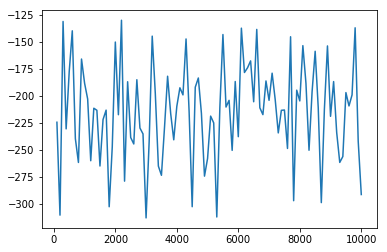

In [79]:
# from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(), key=first_arg))
plt.plot(iters, np.array(session_rewards))